## Etape 3: analyse des sentiments des avis clients

### Chargement et préparation des données

In [113]:
import json
import pandas as pd

In [114]:
# Lecture du fichier JSONL
reviews = []
with open("data/reviews.jsonl", "r", encoding="utf-8") as file:
    for line in file:
        review = json.loads(line)
        reviews.append({
            "rating": review["rating"],
            "title": review["title"],
            "text": review["text"],  # Combinaison du titre et du texte
        })

In [115]:
original_reviews_df = pd.DataFrame(reviews)
original_reviews_df.head()

,rating,title,text
0,4.0,No white background! It’s clear!,I bought this bc I thought it had the nice whi...
1,5.0,Awesome! Great price! Works well!,Perfect. How pissed am I that I recently paid ...
2,5.0,Worked but took an hour to install,Overall very happy with the end result. If you...
3,4.0,Decent,Lasted about 9 months then the lock button bro...
4,5.0,LOVE IT!,LOVE THIS CASE! Works better than my expensive...


In [116]:
# Prendre 200 lignes aléatoires pour l'analyse
reviews_df = original_reviews_df.sample(200, random_state=42)

### Chargement du modèle pré-entraîné

In [117]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [118]:
# 2. Chargement du modèle et du tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model_tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [119]:
# Permet de passer le modèle sur le GPU si celui-ci est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [120]:
# Mettre le modèle en mode évaluation
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [121]:
print("Modèle chargé sur:", device)

Modèle chargé sur: cpu


### Prétraitement des données

In [122]:
from torch.utils.data import Dataset, DataLoader
from typing import List, Dict, Any
import torch
from transformers import AutoTokenizer
import pandas as pd

In [123]:
class ReviewDataset(Dataset):
    def __init__(
        self,
        reviews_df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_length: int = 512
    ) -> None:
        self.reviews = reviews_df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.reviews)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        review = self.reviews.iloc[idx]
        
        # Combiner titre et texte pour le traitement
        text = f"{review['title']} {review['text']}"
        
        # Tokenisation
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'rating': torch.tensor(review['rating'], dtype=torch.float)
        }

In [124]:
def create_data_loader(
    df: pd.DataFrame,
    tokenizer: AutoTokenizer,
    batch_size: int = 8,
    max_length: int = 512
) -> DataLoader:
    """
    Crée un DataLoader pour les reviews
    """
    dataset = ReviewDataset(
        reviews_df=df,
        tokenizer=tokenizer,
        max_length=max_length
    )
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )

In [125]:
# Création du DataLoader
batch_size = 8  # Ajustez selon vos ressources
dataloader = create_data_loader(reviews_df, model_tokenizer, batch_size=batch_size)

In [126]:
first_batch = next(iter(dataloader))
print("Taille du batch:")
print(f"Input IDs shape: {first_batch['input_ids'].shape}")
print(f"Attention mask shape: {first_batch['attention_mask'].shape}")
print(f"Ratings shape: {first_batch['rating'].shape}")

Taille du batch:
Input IDs shape: torch.Size([8, 512])
Attention mask shape: torch.Size([8, 512])
Ratings shape: torch.Size([8])


### Analyse des sentiments

In [127]:
from typing import Dict, List, Tuple
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader

In [128]:
def predict_sentiment(
    model: AutoModelForSequenceClassification,
    dataloader: DataLoader,
    device: torch.device
) -> Tuple[List[float], List[float]]:
    """
    Prédit les sentiments pour tous les reviews dans le dataloader
    
    Returns:
        Tuple contenant les prédictions et les vraies notes
    """
    predictions = []
    actual_ratings = []
    
    # Désactive le calcul des gradients pour l'inférence
    with torch.no_grad():
        for batch in dataloader:
            # Déplace les données sur le device approprié
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ratings = batch['rating'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Applique softmax pour obtenir les probabilités
            probs = F.softmax(outputs.logits, dim=1)
            
            # Obtient l'indice de la classe la plus probable et ajoute 1 
            # car les labels sont de 1 à 5
            predicted_ratings = torch.argmax(probs, dim=1) + 1
            
            # Stocke les prédictions et les vraies notes
            predictions.extend(predicted_ratings.cpu().tolist())
            actual_ratings.extend(ratings.cpu().tolist())
    
    return predictions, actual_ratings

In [129]:
def calculate_metrics(
    predictions: List[float],
    actual_ratings: List[float]
) -> Dict[str, float]:
    """
    Calcule les métriques de performance
    """
    predictions_tensor = torch.tensor(predictions)
    actual_ratings_tensor = torch.tensor(actual_ratings)
    
    # Calcul de la corrélation de Pearson
    correlation = torch.corrcoef(
        torch.stack([predictions_tensor.float(), actual_ratings_tensor.float()])
    )[0,1].item()
    
    # Calcul de l'exactitude (prédictions exactes)
    accuracy = (predictions_tensor == actual_ratings_tensor).float().mean().item()
    
    return {
        "correlation": correlation,
        "accuracy": accuracy
    }

In [130]:
# Exécution des prédictions
predictions, actual_ratings = predict_sentiment(model, dataloader, device)

In [131]:
# Calcul et affichage des métriques
metrics = calculate_metrics(predictions, actual_ratings)
print("\nMétriques de performance:")
print(f"Corrélation de Pearson: {metrics['correlation']:.3f}")
print(f"Exactitude: {metrics['accuracy']:.3f}")


Métriques de performance:
Corrélation de Pearson: 0.874
Exactitude: 0.730


### Bonus: Visualisation des résultats

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import numpy as np

In [133]:
def create_comparison_plots(
        predictions: List[float],
        actual_ratings: List[float],
        figsize: Tuple[int, int] = (15, 5)
) -> None:
    """
    Crée des visualisations comparatives entre les notes prédites et réelles
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

    # 1. Distribution des notes réelles vs prédites
    df_plot = pd.DataFrame({
        'Prédictions': predictions,
        'Notes réelles': actual_ratings
    })

    sns.kdeplot(data=df_plot, ax=ax1)
    ax1.set_title('Distribution des notes')
    ax1.set_xlabel('Note (1-5)')
    ax1.set_ylabel('Densité')

    # 2. Boîte à moustaches
    df_plot_melted = df_plot.melt(var_name='Type', value_name='Note')
    sns.boxplot(data=df_plot_melted, x='Type', y='Note', ax=ax2)
    ax2.set_title('Boîte à moustaches des notes')

    # 3. Heatmap de confusion
    confusion = np.zeros((5, 5))
    for pred, actual in zip(predictions, actual_ratings):
        confusion[int(pred - 1)][int(actual - 1)] += 1

    sns.heatmap(
        confusion,
        annot=True,
        fmt='g',
        cmap='YlOrRd',
        ax=ax3,
        xticklabels=range(1, 6),
        yticklabels=range(1, 6)
    )
    ax3.set_title('Matrice de confusion')
    ax3.set_xlabel('Notes réelles')
    ax3.set_ylabel('Prédictions')

    plt.tight_layout()
    plt.show()

In [134]:
def print_detailed_stats(
        predictions: List[float],
        actual_ratings: List[float]
) -> None:
    """
    Affiche des statistiques détaillées sur les prédictions
    """
    pred_series = pd.Series(predictions)
    actual_series = pd.Series(actual_ratings)

    stats = {
        'Moyenne des prédictions': pred_series.mean(),
        'Moyenne des notes réelles': actual_series.mean(),
        'Écart-type des prédictions': pred_series.std(),
        'Écart-type des notes réelles': actual_series.std(),
        'Médiane des prédictions': pred_series.median(),
        'Médiane des notes réelles': actual_series.median()
    }

    print("\nStatistiques détaillées:")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")

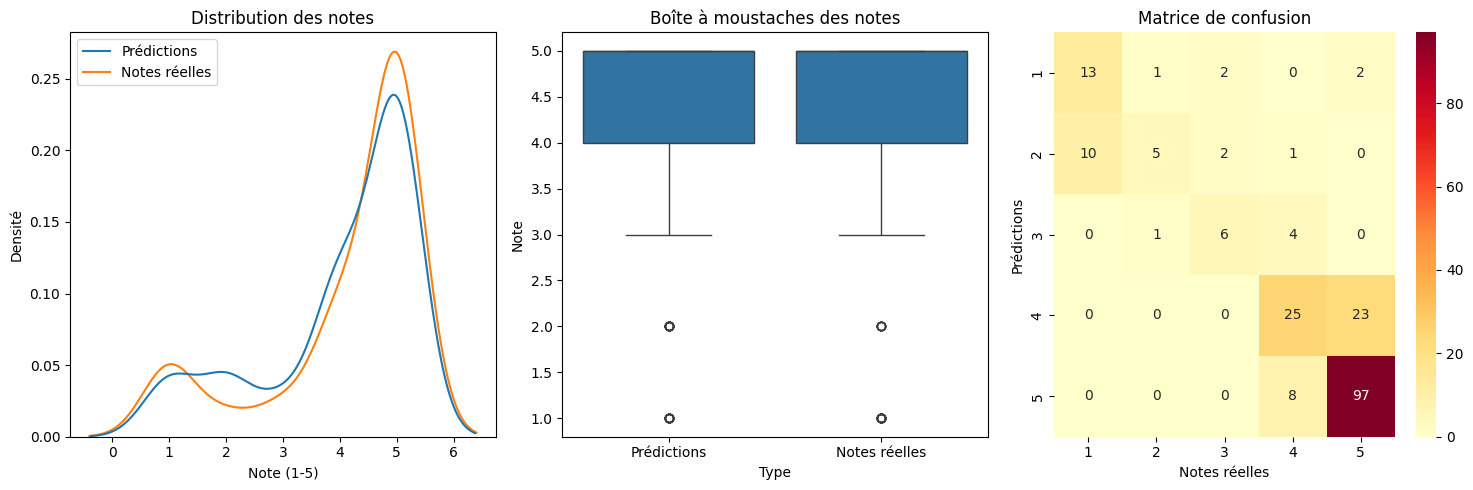

In [135]:
# Création des visualisations
create_comparison_plots(predictions, actual_ratings)

Grâce aux graph ci-dessus, on peut constater que le modèle interprète très bien les sentiments des commentaires, puisqu'il retrouve les notes données par les clients. Les notes prédites sont très proches des notes réelles, voire identifiques.

In [136]:
print_detailed_stats(predictions, actual_ratings)


Statistiques détaillées:
Moyenne des prédictions: 4.02
Moyenne des notes réelles: 4.14
Écart-type des prédictions: 1.33
Écart-type des notes réelles: 1.35
Médiane des prédictions: 5.00
Médiane des notes réelles: 5.00
